In [1]:
#| default_exp training

In [2]:
#|export
# import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import pickle,gzip,math,os,time,shutil,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
# from torch import tensor,nn
# import torch.nn.functional as F
import tensorflow as tf

2023-11-14 12:16:10.096109: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 12:16:10.117122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 12:16:10.117148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 12:16:10.117168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 12:16:10.121876: I tensorflow/core/platform/cpu_feature_g

In [3]:
from fastcore.test import test_close

# torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
# torch.manual_seed(1)
tf.random.set_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tf.constant, [x_train, y_train, x_valid, y_valid])

2023-11-14 12:16:11.339790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:16:11.349823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:16:11.349921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Initial setup

### Data

In [4]:
n,m = x_train.shape
# c = y_train.max()+1
c = tf.reduce_max(y_train) + 1
nh = 50

In [5]:
# class Model(nn.Module):
#     def __init__(self, n_in, nh, n_out):
#         super().__init__()
#         self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
#     def __call__(self, x):tensor
#         for l in self.layers: x = l(x)
#         return x

class Model(tf.keras.Model):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self._layers = [tf.keras.layers.Dense(nh, activation='relu'), tf.keras.layers.Dense(n_out)]

    def __call__(self, x):
        for l in self._layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

2023-11-14 12:16:11.798620: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


TensorShape([50000, 10])

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [7]:
# def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()
def log_softmax(x): return tf.math.log((tf.exp(x)/(tf.reduce_sum(tf.exp(x), axis=-1,keepdims=True))))

In [8]:
log_softmax(pred)

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[-1.4887441, -2.200501 , -2.5600355, ..., -2.6581743, -2.763254 ,
        -2.4057438],
       [-1.275579 , -2.736883 , -2.7763424, ..., -2.6369274, -2.7709646,
        -1.7610989],
       [-2.1507761, -2.2505717, -2.574601 , ..., -2.4686894, -2.2158954,
        -2.3101346],
       ...,
       [-1.5791084, -1.9851043, -3.1372943, ..., -2.184501 , -2.6966004,
        -1.911767 ],
       [-2.0571926, -2.044962 , -2.9081607, ..., -2.4917684, -2.4501157,
        -2.1527672],
       [-1.8914988, -2.0249078, -3.0723257, ..., -2.4146967, -2.3913155,
        -2.2805896]], dtype=float32)>

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [9]:
# def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
def log_softmax(x): return x - tf.math.log(tf.reduce_sum(tf.exp(x), axis=-1,keepdims=True))

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [10]:
# def logsumexp(x):
#     m = x.max(-1)[0]
#     return m + (x-m[:,None]).exp().sum(-1).log()

def logsumexp(x):
    m = tf.reduce_max(x, axis=-1)[0]
    return m + tf.math.log(tf.reduce_sum(tf.exp(x-m[:,None]), axis=-1))

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [11]:
# def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)
def log_softmax(x): return x - tf.math.reduce_logsumexp(x, axis=-1, keepdims=True)

In [12]:
# test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[-1.488744 , -2.200501 , -2.5600352, ..., -2.658174 , -2.763254 ,
        -2.4057436],
       [-1.2755791, -2.736883 , -2.7763424, ..., -2.6369274, -2.7709646,
        -1.7610987],
       [-2.150776 , -2.250572 , -2.574601 , ..., -2.4686894, -2.2158954,
        -2.3101346],
       ...,
       [-1.5791084, -1.9851044, -3.1372943, ..., -2.184501 , -2.6966004,
        -1.911767 ],
       [-2.0571926, -2.044962 , -2.9081607, ..., -2.4917681, -2.4501157,
        -2.152767 ],
       [-1.891499 , -2.0249078, -3.0723257, ..., -2.414697 , -2.3913157,
        -2.2805896]], dtype=float32)>

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [13]:
y_train[:3]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([5, 0, 4])>

In [14]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(<tf.Tensor: shape=(), dtype=float32, numpy=-2.987012>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.2755791>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.8298607>)

In [15]:
sm_pred[0,5]

<tf.Tensor: shape=(), dtype=float32, numpy=-2.987012>

In [16]:
# sm_pred[[0,1,2], y_train[:3]]
tf.experimental.numpy.take_along_axis(sm_pred[:3], y_train[:3, None], axis=1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-2.987012 ],
       [-1.2755791],
       [-1.8298607]], dtype=float32)>

In [17]:
# def nll(input, target): return -input[range(target.shape[0]), target].mean()
def nll(input, target): return tf.reduce_mean(-tf.experimental.numpy.take_along_axis(input[:target.shape[0]], target[:, None], axis=-1))

In [18]:
loss = nll(sm_pred, y_train)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.3962128>

Then use PyTorch's implementation.

In [19]:
# test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)
# test_close(
tf.nn.sparse_softmax_cross_entropy_with_logits(y_train, pred)
# , loss, 1e-3
# )

<tf.Tensor: shape=(50000,), dtype=float32, numpy=
array([2.987012 , 1.275579 , 1.8298607, ..., 2.6966004, 2.4854474,
       2.3913155], dtype=float32)>

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [20]:
# test_close(F.cross_entropy(pred, y_train), loss, 1e-3)
# TensorFlow version above is official.

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [31]:
# loss_func = F.cross_entropy
loss_func = lambda true, preds: tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(true, preds))

In [32]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 0.8962548 ,  0.18449777, -0.17503658,  0.153887  , -0.0495261 ,
        -0.60201323,  0.24323606, -0.27317542, -0.37825516, -0.02074499],
       dtype=float32)>,
 TensorShape([50, 10]))

In [33]:
yb = y_train[0:bs]
yb

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3])>

In [34]:
loss_func(yb, preds)

<tf.Tensor: shape=(), dtype=float32, numpy=119.65227>

In [35]:
# preds.argmax(dim=1)
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([0, 0, 4, 4, 4, 0, 9, 0, 0, 9, 0, 9, 0, 9, 0, 0, 0, 0, 4, 0, 4, 0,
       6, 4, 9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6,
       0, 4, 0, 0, 0, 0])>

In [36]:
#|export
# def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [37]:
#|export
def accuracy(out, yb): return tf.reduce_mean(tf.cast(tf.argmax(out, axis=1)==yb, tf.float32))

In [38]:
accuracy(preds, yb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14>

In [39]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [41]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [42]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(yb, preds), preds, yb)

119.65, 0.14


In [43]:
# for epoch in range(epochs):
#     for i in range(0, n, bs):
#         s = slice(i, min(n,i+bs))
#         xb,yb = x_train[s],y_train[s]
#         preds = model(xb)
#         loss = loss_func(preds, yb)
#         loss.backward()
#         with torch.no_grad():
#             for l in model.layers:
#                 if hasattr(l, 'weight'):
#                     l.weight -= l.weight.grad * lr
#                     l.bias   -= l.bias.grad   * lr
#                     l.weight.grad.zero_()
#                     l.bias  .grad.zero_()
#     report(loss, preds, yb)

In [44]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        with tf.GradientTape() as tape:
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = tf.reduce_sum(loss_func(yb, preds))
        grads = tape.gradient(loss, model.trainable_variables)
        for n, l in enumerate(model.layers):
            if hasattr(l, 'weights'):
                n = n*2
                l.weights[0].assign_sub(grads[n]*lr)
                l.weights[1].assign_sub(grads[n+1]*lr)
    report(loss, preds, yb)

0.00, nan
206.98, 0.00
0.00, 1.00


## Using parameters and optim

### Parameters

In [45]:
# m1 = nn.Module()
# m1.foo = nn.Linear(3,4)
# m1

In [46]:
m1 = tf.keras.Model()
m1.foo = tf.keras.layers.Dense(4)
m1

In [47]:
# list(m1.named_children())

In [48]:
# You would usually do this but the model doesn't have a correct forward pass and so it won't work
m1.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [49]:
# m1.named_children()

In [50]:
# list(m1.parameters())

In [51]:
# This is empty because the model is not initialized
list(m1.trainable_variables)

[]

In [52]:
# class MLP(nn.Module):
#     def __init__(self, n_in, nh, n_out):
#         super().__init__()
#         self.l1 = nn.Linear(n_in,nh)
#         self.l2 = nn.Linear(nh,n_out)
#         self.relu = nn.ReLU()
        
#     def forward(self, x): return self.l2(self.relu(self.l1(x)))

class MLP(tf.keras.Model):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = tf.keras.layers.Dense(nh, activation='relu')
        self.l2 = tf.keras.layers.Dense(n_out)
        
    def call(self, x): return self.l2(self.l1(x))

In [53]:
model = MLP(m, nh, 10)
model.l1

In [54]:
model

In [55]:
# for name,l in model.named_children(): print(f"{name}: {l}")

model.build(input_shape=(None,3))
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  200       
                                                                 
 dense_4 (Dense)             multiple                  510       
                                                                 
Total params: 710 (2.77 KB)
Trainable params: 710 (2.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# for p in model.parameters(): print(p.shape)

for p in model.trainable_weights: print(p.shape)

(3, 50)
(50,)
(50, 10)
(10,)


In [57]:
# def fit():
#     for epoch in range(epochs):
#         for i in range(0, n, bs):
#             s = slice(i, min(n,i+bs))
#             xb,yb = x_train[s],y_train[s]
#             preds = model(xb)
#             loss = loss_func(preds, yb)
#             loss.backward()
#             with torch.no_grad():
#                 for p in model.parameters(): p -= p.grad * lr
#                 model.zero_grad()
#         report(loss, preds, yb)

def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            with tf.GradientTape() as tape:
                s = slice(i, min(n,i+bs))
                xb,yb = x_train[s],y_train[s]
                preds = model(xb)
                loss = tf.reduce_sum(loss_func(yb, preds))
            grads = tape.gradient(loss, model.trainable_variables)
            for n, l in enumerate(model.layers):
                if hasattr(l, 'weights'):
                    n = n*2
                    l.weights[0].assign_sub(grads[n])
                    l.weights[1].assign_sub(grads[n+1])
        report(loss, preds, yb)

In [58]:
fit()

UnboundLocalError: local variable 'n' referenced before assignment

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [59]:
# class MyModule:
#     def __init__(self, n_in, nh, n_out):
#         self._modules = {}
#         self.l1 = nn.Linear(n_in,nh)
#         self.l2 = nn.Linear(nh,n_out)

#     def __setattr__(self,k,v):
#         if not k.startswith("_"): self._modules[k] = v
#         super().__setattr__(k,v)

#     def __repr__(self): return f'{self._modules}'
    
#     def parameters(self):
#         for l in self._modules.values(): yield from l.parameters()


class MyModule:
    def __init__(self, n_in, nh, n_out):
        super().__init__() 

        self._modules = {}

        self.l1 = tf.keras.layers.Dense(nh)
        self.l2 = tf.keras.layers.Dense(n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for w in sum(list(map(lambda v: v.weights, mdl._modules.values())), []): yield w

In [60]:
mdl = MyModule(m,nh,10)
mdl

{'l1': <keras.src.layers.core.dense.Dense object at 0x7f415b76ac80>, 'l2': <keras.src.layers.core.dense.Dense object at 0x7f415b76b220>}

In [61]:
# Still empty due to tensorflow compiling
for p in mdl.parameters(): print(p.shape)

### Registering modules

In [62]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [63]:
# layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
layers = [tf.keras.layers.Dense(nh, activation='relu'), tf.keras.layers.Dense(10)]

In [64]:
# class Model(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.layers = layers
#         for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

#     def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

class Model(tf.keras.Model):
    def __init__(self, layers):
        super().__init__()
        self._layers = layers
        # for i,l in enumerate(self._layers): self.add_module(f'layer_{i}', l)

    def call(self, x): return reduce(lambda val,layer: layer(val), self._layers, x)


In [65]:
model = Model(layers)
model

In [66]:
model.compile()

In [67]:
model(xb).shape

TensorShape([2, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [68]:
# class SequentialModel(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.layers = nn.ModuleList(layers)
        
#     def forward(self, x):
#         for l in self.layers: x = l(x)
#         return x

class SequentialModel(tf.keras.Model):
    def __init__(self, layers):
        super().__init__()
        self._layers = layers

    def call(self, x):
        for l in self._layers: x = l(x)
        return x

In [69]:
model = SequentialModel(layers)
model

In [70]:
fit()

UnboundLocalError: local variable 'n' referenced before assignment

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [71]:
# model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model = tf.keras.Sequential(tf.keras.layers.Dense(nh, activation='relu'), tf.keras.layers.Dense(10))

In [72]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

UnboundLocalError: local variable 'n' referenced before assignment

In [73]:
model

In [74]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

### optim

In [75]:
# class Optimizer():
#     def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

#     def step(self):
#         with torch.no_grad():
#             for p in self.params: p -= p.grad * self.lr

#     def zero_grad(self):
#         for p in self.params: p.grad.data.zero_()


class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self, grads):
        for n, p in enumerate(self.params): p.assign_sub(grad[i] * self.lr)

    def zero_grad(self):
        pass

In [76]:
# model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model = tf.keras.Sequential(tf.keras.layers.Dense(nh, activation='relu'), tf.keras.layers.Dense(10))

In [77]:
model.build(input_shape=(None, 3))

In [78]:
# opt = Optimizer(model.parameters())
opt = Optimizer(model.trainable_variables)

In [79]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

ValueError: name for name_scope must be a string.

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [80]:
# from torch import optim
from tensorflow.keras import optimizers

In [81]:
# def get_model():
#     model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
#     return model, optim.SGD(model.parameters(), lr=lr)

def get_model():
    model = tf.keras.Sequential(tf.keras.layers.Dense(nh, activation='relu'), tf.keras.layers.Dense(10))
    opt = optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=opt)
    return model, opt

In [82]:
model,opt = get_model()
# loss_func(model(xb), yb)

In [83]:
?????????????? Need to do 

Object `???????????? Need to do` not found.


In [84]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

ValueError: name for name_scope must be a string.

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [85]:
# #|export
# class Dataset():
#     def __init__(self, x, y): self.x,self.y = x,y
#     def __len__(self): return len(self.x)
#     def __getitem__(self, i): return self.x[i],self.y[i]

In [86]:
# train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
# assert len(train_ds)==len(x_train)
# assert len(valid_ds)==len(x_valid)

In [87]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [88]:
# xb,yb = train_ds[0:5]
xb, yb = [i for i in train_ds.batch(5).take(1)][0]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(<tf.Tensor: shape=(5, 784), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([5, 0, 4, 1, 9])>)

In [89]:
model,opt = get_model()

In [90]:
?????????????? Need to do

Object `???????????? Need to do` not found.


In [91]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

TypeError: '_TensorSliceDataset' object is not subscriptable

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [92]:
# class DataLoader():
#     def __init__(self, ds, bs): self.ds,self.bs = ds,bs
#     def __iter__(self):
#         for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [93]:
# train_dl = DataLoader(train_ds, bs)
# valid_dl = DataLoader(valid_ds, bs)

In [94]:
# xb,yb = next(iter(valid_dl))
# xb.shape

In [95]:
# yb

<tf.Tensor: shape=(), dtype=int64, numpy=5>

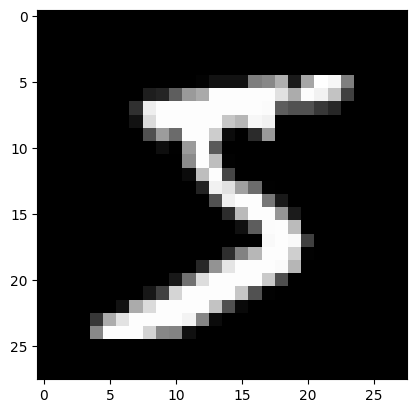

In [96]:
# plt.imshow(xb[0].view(28,28))
plt.imshow(tf.reshape(xb[0], shape=(28,28)))
yb[0]

In [97]:
model,opt = get_model()

In [98]:
????????? NEED TO DO

Object `??????? NEED TO DO` not found.


In [99]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [100]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

NameError: name 'train_dl' is not defined

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [101]:
import random

In [102]:
# class Sampler():
#     def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
#     def __iter__(self):
#         res = list(range(self.n))
#         if self.shuffle: random.shuffle(res)
#         return iter(res)

In [103]:
# from itertools import islice

In [104]:
# ss = Sampler(train_ds)

In [105]:
# it = iter(ss)
# for o in range(5): print(next(it))

In [106]:
# list(islice(ss, 5))

In [107]:
# ss = Sampler(train_ds, shuffle=True)
# list(islice(ss, 5))

In [108]:
# import fastcore.all as fc

In [109]:
# class BatchSampler():
#     def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
#     def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [110]:
# batchs = BatchSampler(ss, 4)
# list(islice(batchs, 5))

In [111]:
# def collate(b):
#     xs,ys = zip(*b)
#     return torch.stack(xs),torch.stack(ys)

In [112]:
# class DataLoader():
#     def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
#     def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [113]:
# train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
# valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [114]:
# train_dl = DataLoader(train_ds, batchs=train_samp)
# valid_dl = DataLoader(valid_ds, batchs=valid_samp)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

train_dl = train_ds.shuffle(1024).batch(bs)
valid_dl = train_ds.batch(bs)


<tf.Tensor: shape=(), dtype=int64, numpy=5>

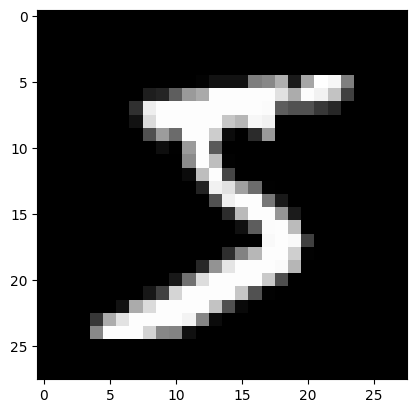

In [115]:
xb,yb = next(iter(valid_dl))
# plt.imshow(xb[0].view(28,28))
plt.imshow(tf.reshape(xb[0], shape=(28,28)))
yb[0]

In [116]:
xb.shape,yb.shape

(TensorShape([50, 784]), TensorShape([50]))

In [117]:
model,opt = get_model()

In [118]:
fit()

ValueError: name for name_scope must be a string.

### Multiprocessing DataLoader

In [119]:
# import torch.multiprocessing as mp
# from fastcore.basics import store_attr

In [120]:
# train_ds[[3,6,8,1]]

In [121]:
# train_ds.__getitem__([3,6,8,1])

In [122]:
# for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

In [123]:
# class DataLoader():
#     def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
#     def __iter__(self):
#         with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [124]:
# train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
# it = iter(train_dl)

In [125]:
it = iter(train_dl.prefetch(tf.data.AUTOTUNE))

In [126]:
xb,yb = next(it)
xb.shape,yb.shape

(TensorShape([50, 784]), TensorShape([50]))

### PyTorch DataLoader

In [127]:
# #|export
# from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [128]:
# train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
# valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [129]:
# train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
# valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [130]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

ValueError: name for name_scope must be a string.

PyTorch can auto-generate the BatchSampler for us:

In [131]:
# train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
# valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [132]:
# train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
# valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [133]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

ValueError: name for name_scope must be a string.

Our dataset actually already knows how to sample a batch of indices all at once:

In [134]:
# train_ds[[4,6,7]]

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [135]:
# train_dl = DataLoader(train_ds, sampler=train_samp)
# valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [136]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(TensorShape([50, 784]), TensorShape([50]))

## Validation

# ??????????? NEED TO DO 

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [137]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [138]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [139]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

NameError: name 'DataLoader' is not defined

In [140]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

AttributeError: 'Sequential' object has no attribute 'train'

## Export -

In [143]:
import nbdev; nbdev.nbdev_export()